# Fine-Tune Linear SVM

## Load Libraries

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

## Utils

In [2]:
def load_data(filename):
    """
    Input: string filename
    Output: a pandas dataframe for the whole dataset after droping missing values
    Support google colab or local environments
    """
    try:
        # local environment
        df = pd.read_csv(filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df
    except:
        # google colab environment
        from google.colab import drive
        drive.mount('/content/drive')
        
        df = pd.read_csv('/content/drive/MyDrive/' + filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df

In [3]:
def split_data(df):
    """
    Input: pandas dataframe
    Output: training dataframe (81%), validation dataframe (9%), test dataframe (10%)
    """
    df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
    
    return df_train, df_val

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        Input: string text
        Output: string cleaned text
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

## Load data

In [5]:
FILENAME = 'final_dataset_formatted.csv'
TEST_FILENAME = 'final_dataset_formatted_test.csv'

# load data
df = load_data(FILENAME)
df_test = load_data(TEST_FILENAME)

# labels
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']
num_labels = 9

# split data
df_train, df_val = split_data(df)

## Preprocess data

In [6]:
# clean text
df_train['sentence'] = df_train['sentence'].apply(clean_text)
df_val['sentence'] = df_val['sentence'].apply(clean_text)
df_test['sentence'] = df_test['sentence'].apply(clean_text)

In [7]:
# print processed sample data sentence
df_train.iloc[10, 0]

'total weight waste type disposal method'

In [8]:
# split text and labels
train_texts = df_train.iloc[:, 0]
train_labels = df_train.iloc[:, 1]
valid_texts = df_val.iloc[:, 0]
valid_labels = df_val.iloc[:, 1]
test_texts = df_test.iloc[:, 0]
test_labels = df_test.iloc[:, 1]

In [9]:
# get train, validation, and test dataset size
train_size = len(train_texts)
valid_size = len(valid_texts)
test_size = len(test_texts)

print(f'train size: {train_size}')
print(f'valid size: {valid_size}')
print(f'test size: {test_size}')

train size: 3645
valid size: 405
test size: 450


## Fine-Tune Model

In [10]:
alpha_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1] #1e-3
max_iter_list = [1, 3, 5, 10, 15, 50, 100] #5

best_alpha = 0
best_max_iter = 0
best_acc = 0
max_f1 = 0

for alpha in alpha_list:
    for max_iter in max_iter_list:
        
        # build model
        sgd = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=alpha, random_state=42, max_iter=max_iter, tol=None)),
                       ])
        # train model
        sgd.fit(train_texts, train_labels)

        # generate prediction
        y_pred = sgd.predict(valid_texts)

        # evaluate performance
        acc = accuracy_score(valid_labels, y_pred)
        f1 = f1_score(valid_labels, y_pred, average='macro')
#         print(f'alpha: {alpha}, max_iter: {max_iter}:')
#         print(f'accuracy: {acc:.4f}')
#         print(f'macro_f1: {f1:.4f}')

        # find best model (highest macro_f1 score)
        if f1 >= max_f1:
            best_alpha = alpha
            best_max_iter = max_iter
            best_acc = acc
            max_f1 = f1
        
#         print()

print(f'Best model: ')
print(f'alpha: {best_alpha}, max_iter: {max_iter}, acc: {best_acc}, macro_f1: {max_f1}')

Best model: 
alpha: 0.001, max_iter: 100, acc: 0.8271604938271605, macro_f1: 0.8263163640712641


## Final Linear SVM Model

In [11]:
# build model
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=best_alpha, random_state=42, max_iter=best_max_iter, tol=None)),
               ])
# train model
sgd.fit(train_texts, train_labels)

# generate prediction
y_pred = sgd.predict(valid_texts)
f1 = f1_score(valid_labels, y_pred, average='macro')

# evaluate model performance
print('accuracy %s' % accuracy_score(y_pred, valid_labels))
print(f'macro_f1 score: {f1}')
print(classification_report(valid_labels, y_pred,target_names=labels))

accuracy 0.8271604938271605
macro_f1 score: 0.8263163640712641
              precision    recall  f1-score   support

          CC       0.75      0.87      0.80        45
          NC       0.93      0.84      0.88        45
          PW       0.89      0.91      0.90        45
          HC       0.83      0.67      0.74        45
          PL       0.74      0.82      0.78        45
          CR       0.84      0.80      0.82        45
          CG       0.78      0.96      0.86        45
          BE       0.82      0.73      0.78        45
           N       0.90      0.84      0.87        45

    accuracy                           0.83       405
   macro avg       0.83      0.83      0.83       405
weighted avg       0.83      0.83      0.83       405



## Final Model Test Prediction

In [12]:
# generate prediction
y_pred = sgd.predict(test_texts)
f1 = f1_score(test_labels, y_pred, average='macro')

# evaluate model performance
print('accuracy %s' % accuracy_score(y_pred, test_labels))
print(f'macro_f1 score: {f1}')
print(classification_report(test_labels, y_pred,target_names=labels))

accuracy 0.8488888888888889
macro_f1 score: 0.8483276313714592
              precision    recall  f1-score   support

          CC       0.89      0.94      0.91        50
          NC       0.88      0.92      0.90        50
          PW       0.86      0.88      0.87        50
          HC       0.88      0.72      0.79        50
          PL       0.72      0.84      0.78        50
          CR       0.88      0.76      0.82        50
          CG       0.88      0.88      0.88        50
          BE       0.85      0.82      0.84        50
           N       0.81      0.88      0.85        50

    accuracy                           0.85       450
   macro avg       0.85      0.85      0.85       450
weighted avg       0.85      0.85      0.85       450



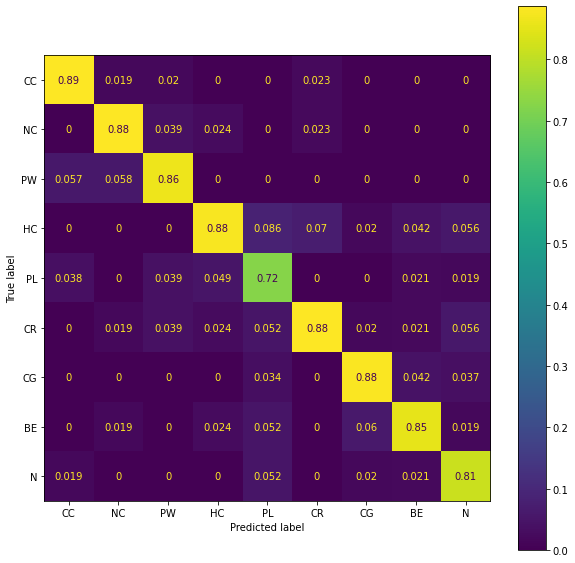

In [13]:
# plot confusion matrix
cm = confusion_matrix(test_labels, y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)